In [8]:
import rebound
import numpy as np
from numpy.random import random, seed
import matplotlib.pyplot as plt
from rebound import InterruptiblePool        
from spock import StabilityClassifier
from celmech import Andoyer
import pandas as pd

%matplotlib inline

In [2]:
def samplesim(s, m0, m, a, emax=1):
    seed(s)
    sim = rebound.Simulation()
    sim.add(m=m0)
    for mass, sma in zip(m,a):
        sim.add(m=mass, a=sma, e=np.sqrt(random()*emax**2), pomega=random()*2*np.pi, M=random()*2*np.pi)
    return sim

def tremaine_stable(sim, Deltacrit=9):
    ps = sim.particles
    abar = np.array([p.a for p in ps[1:]]).mean()
    for i in range(1,sim.N-1):
        if ps[i+1].a-ps[i].a-abar*(ps[i].e+ps[i+1].e)-Deltacrit*abar*((ps[i].m+ps[i+1].m)/3/ps[0].m)**(1/3) < 0:
            return 0
    return 1

def calcarrays(sim):
    ps = sim.particles
    m0 = ps[0].m
    m = np.array([p.m for p in ps[1:]])
    a = np.array([p.a for p in ps[1:]])
    
    abar = np.array([p.a for p in ps[1:]]).mean()
    ecross = np.array([ps[i+1].a-ps[i].a for i in range(1,sim.N-1)])/abar
    ehill = np.array([((ps[i].m+ps[i+1].m)/3./ps[0].m)**(1/3) for i in range(1,sim.N-1)])
    return m0, abar, m, a, ecross, ehill

def runSPOCK(args):
    s, m0, m, a, emax = args
    sim = samplesim(s, m0, m, a, emax)
    ps = sim.particles
    Z12 = Andoyer.from_Simulation(sim, j=3, k=1, i1=1, i2=2, average=False).Z
    Z23 = Andoyer.from_Simulation(sim, j=7, k=2, i1=2, i2=3, average=False).Z
    hcom = (ps[1].m*ps[1].e*np.cos(ps[1].pomega) + ps[2].m*ps[2].e*np.cos(ps[2].pomega) + ps[3].m*ps[3].e*np.cos(ps[3].pomega))/(ps[1].m+ps[2].m+ps[3].m)
    kcom = (ps[1].m*ps[1].e*np.sin(ps[1].pomega) + ps[2].m*ps[2].e*np.sin(ps[2].pomega) + ps[3].m*ps[3].e*np.sin(ps[3].pomega))/(ps[1].m+ps[2].m+ps[3].m)
    ecom = np.sqrt(hcom**2 + kcom**2)
    
    return [ps[1].e, ps[2].e, ps[3].e, Z12, Z23, ecom, tremaine_stable(sim), sc.predict_stable(sim)]

def runT15(args):
    s, m0, m, a, emax = args
    sim = samplesim(s, m0, m, a, emax)
    ps = sim.particles
    Z12 = Andoyer.from_Simulation(sim, j=3, k=1, i1=1, i2=2, average=False).Z
    Z23 = Andoyer.from_Simulation(sim, j=7, k=2, i1=2, i2=3, average=False).Z
    hcom = (ps[1].m*ps[1].e*np.cos(ps[1].pomega) + ps[2].m*ps[2].e*np.cos(ps[2].pomega) + ps[3].m*ps[3].e*np.cos(ps[3].pomega))/(ps[1].m+ps[2].m+ps[3].m)
    kcom = (ps[1].m*ps[1].e*np.sin(ps[1].pomega) + ps[2].m*ps[2].e*np.sin(ps[2].pomega) + ps[3].m*ps[3].e*np.sin(ps[3].pomega))/(ps[1].m+ps[2].m+ps[3].m)
    ecom = np.sqrt(hcom**2 + kcom**2)
    
    return [ps[1].e, ps[2].e, ps[3].e, Z12, Z23, ecom, tremaine_stable(sim), sc.predict_stable(sim)]

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f929bc50fd0>)

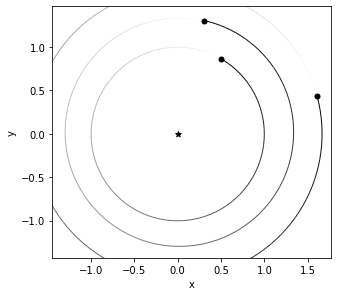

In [3]:
sim = rebound.Simulation('kep23-000140.bin')
m0, abar, m, a, ecross, ehill = calcarrays(sim)
rebound.OrbitPlot(sim)

In [4]:
def init_process():
    global sc
    sc = StabilityClassifier()

pool = InterruptiblePool(processes=48, initializer=init_process)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r 

# SPOCK

In [39]:
%%time
emax=0.5
params = [(i,m0,m,a,emax) for i in range(5000000)]
res = pool.map(runSPOCK, params)

CPU times: user 48.5 s, sys: 18.8 s, total: 1min 7s
Wall time: 2h 55min 31s


In [40]:
dfSPOCK = pd.DataFrame(res, columns=['e1', 'e2', 'e3', 'Z12', 'Z23', 'ecom', 'T15stable', 'SPOCKstable'])
dfSPOCK.tail()
#dfSPOCK.sort_values(by='SPOCKstable').tail()

,e1,e2,e3,Z12,Z23,ecom,T15stable,SPOCKstable
4999995,0.469990,0.223692,0.419171,0.187223,0.294755,0.270850,0,0.0
4999996,0.426852,0.414383,0.499495,0.191098,0.667055,0.089929,0,0.0
4999997,0.353644,0.248677,0.455101,0.192706,0.329576,0.325098,0,0.0
4999998,0.099697,0.322724,0.120649,0.243145,0.290597,0.087334,0,0.0
4999999,0.438787,0.459807,0.427941,0.525261,0.621881,0.173776,0,0.0


In [45]:
dfSPOCK.to_csv('Kep23-SPOCK.csv')

In [49]:
test = dfSPOCK[dfSPOCK['SPOCKstable']>0]

In [50]:
test.shape

(66085, 8)

CPU times: user 66 ms, sys: 679 µs, total: 66.7 ms
Wall time: 62.4 ms


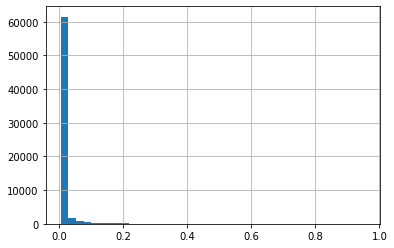

In [51]:
%%time
test['SPOCKstable'].hist(bins=40)

(array([ 4.40000965,  5.2895161 , 10.47237465, 14.256558  , 19.54366076,
        21.11396204, 26.28881876, 35.0768337 , 38.1645516 , 34.3934479 ,
        37.10557336, 39.14410213, 39.91689431, 40.82502376, 39.40362852,
        40.58184482, 38.65181349, 39.53004299, 42.23881453, 37.97417556,
        38.16915123, 34.30252675, 33.76334277, 32.01410368, 29.65070342,
        31.3314098 , 29.52938732, 27.64247056, 25.08637134, 25.48672134,
        24.69950326, 19.63837979, 19.46222017, 17.66009418, 16.09976865,
        13.14737254, 10.68901613,  8.4421789 ,  6.40678087,  4.72377948]),
 array([3.24886643e-04, 1.28162602e-02, 2.53076338e-02, 3.77990073e-02,
        5.02903809e-02, 6.27817545e-02, 7.52731280e-02, 8.77645016e-02,
        1.00255875e-01, 1.12747249e-01, 1.25238622e-01, 1.37729996e-01,
        1.50221369e-01, 1.62712743e-01, 1.75204117e-01, 1.87695490e-01,
        2.00186864e-01, 2.12678237e-01, 2.25169611e-01, 2.37660984e-01,
        2.50152358e-01, 2.62643732e-01, 2.75135105e-01

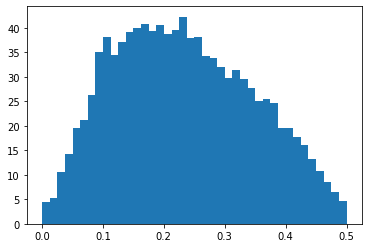

In [52]:
fig, ax = plt.subplots()
ax.hist(test['e2'], weights=test['SPOCKstable'], bins=40)

(array([4.18251452e+01, 1.06159743e+02, 1.28571222e+02, 1.12826350e+02,
        8.22242533e+01, 5.37761687e+01, 4.92489876e+01, 4.45465417e+01,
        4.56852956e+01, 4.29907091e+01, 4.34896372e+01, 4.74888358e+01,
        4.87418356e+01, 4.66048444e+01, 4.19155665e+01, 3.44938388e+01,
        2.91497736e+01, 1.98187049e+01, 1.28522357e+01, 8.06282641e+00,
        4.69616869e+00, 3.14835418e+00, 1.59783062e+00, 7.29989104e-01,
        5.95827788e-01, 3.62425657e-01, 1.36043626e-01, 1.08287870e-01,
        3.69212804e-02, 6.62002098e-02, 1.15095353e-01, 2.79630059e-02,
        4.94208541e-02, 6.47309981e-03, 3.11609944e-02, 2.83999033e-02,
        0.00000000e+00, 8.09808224e-02, 1.86596159e-02, 8.21036473e-03]),
 array([0.00083823, 0.01586988, 0.03090153, 0.04593318, 0.06096483,
        0.07599648, 0.09102813, 0.10605978, 0.12109143, 0.13612309,
        0.15115474, 0.16618639, 0.18121804, 0.19624969, 0.21128134,
        0.22631299, 0.24134464, 0.25637629, 0.27140794, 0.28643959,
      

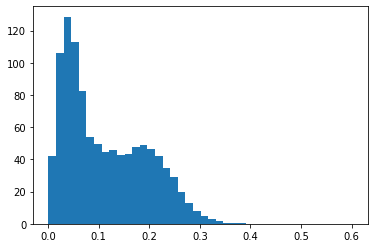

In [53]:
fig, ax = plt.subplots()
ax.hist(test['Z12'], weights=test['SPOCKstable'], bins=40)

(array([7.53339514e+01, 1.87243393e+02, 2.51914397e+02, 2.17015903e+02,
        1.42427551e+02, 8.10759567e+01, 5.04894110e+01, 3.15552906e+01,
        9.79220608e+00, 1.97841562e+00, 7.28982260e-01, 4.46914749e-01,
        1.11997352e-01, 1.23814307e-01, 7.39276083e-02, 2.71367347e-02,
        1.84764365e-01, 1.89305512e-01, 1.99895341e-01, 4.13125420e-01,
        3.49237345e-01, 1.02192690e-01, 4.90294313e-02, 0.00000000e+00,
        3.74873132e-02, 2.10190564e-02, 9.59297922e-03, 1.38696935e-02,
        9.44728060e-02, 2.33518697e-01, 4.05571908e-02, 1.43559724e-02,
        9.01517924e-03, 0.00000000e+00, 8.21036473e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.03004578e-03]),
 array([3.64775174e-04, 1.60147224e-02, 3.16646696e-02, 4.73146168e-02,
        6.29645641e-02, 7.86145113e-02, 9.42644585e-02, 1.09914406e-01,
        1.25564353e-01, 1.41214300e-01, 1.56864247e-01, 1.72514195e-01,
        1.88164142e-01, 2.03814089e-01, 2.19464036e-01, 2.3511

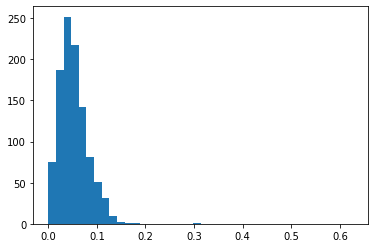

In [57]:
fig, ax = plt.subplots()
ax.hist(test['Z23'], weights=test['SPOCKstable'], bins=40)

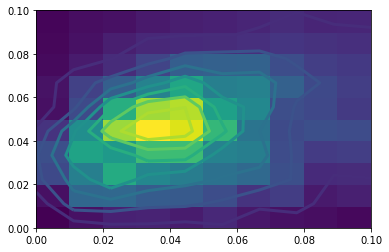

In [92]:
fig, ax = plt.subplots()
counts, xbins, ybins, img = ax.hist2d(test['Z12'], test['Z23'], weights=test['SPOCKstable'], range=([0,0.1], [0,0.1]))
ax.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)

<ErrorbarContainer object of 3 artists>

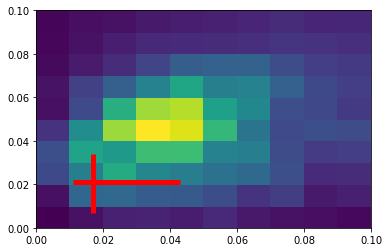

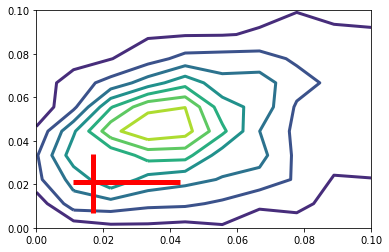

In [103]:
fig, ax = plt.subplots()
counts, xbins, ybins, img = ax.hist2d(test['Z12'], test['Z23'], weights=test['SPOCKstable'], range=([0,0.1], [0,0.1]))
ax.errorbar([0.017], [0.021], elinewidth=5, markersize=200, color='red', xerr=[[0.006], [0.026]], yerr=[[0.014], [0.013]]) 
fig, ax = plt.subplots()
ax.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)
ax.errorbar([0.017], [0.021], elinewidth=5, markersize=200, color='red', xerr=[[0.006], [0.026]], yerr=[[0.014], [0.013]]) 

# T15

In [41]:
emax1 = (a[1]-a[0]-9*ehill[0]*abar)/abar
emax2 = (a[2]-a[1]-9*ehill[1]*abar)/abar
print(emax1, emax2)

0.055916544863602466 0.05067268717216999


In [42]:
%%time
emax=max(emax1,emax2)
params = [(i,m0,m,a,emax) for i in range(200000)]
res = pool.map(runT15, params)

CPU times: user 21 s, sys: 11.7 s, total: 32.7 s
Wall time: 3h 12min 18s


<ErrorbarContainer object of 3 artists>

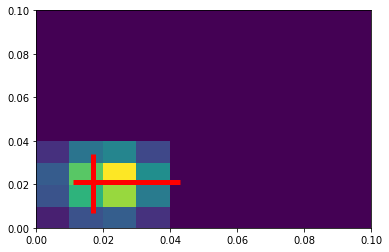

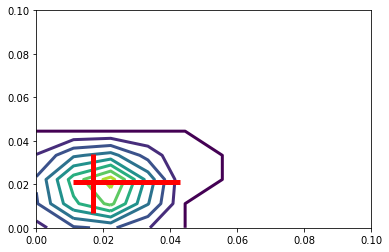

In [104]:
fig, ax = plt.subplots()
counts, xbins, ybins, img = ax.hist2d(dfT15['Z12'], dfT15['Z23'], weights=dfT15['T15stable'], range=([0,0.1], [0,0.1]))
ax.errorbar([0.017], [0.021], elinewidth=5, markersize=200, color='red', xerr=[[0.006], [0.026]], yerr=[[0.014], [0.013]]) 
fig, ax = plt.subplots()
ax.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)
ax.errorbar([0.017], [0.021], elinewidth=5, markersize=200, color='red', xerr=[[0.006], [0.026]], yerr=[[0.014], [0.013]]) 

In [43]:
dfT15 = pd.DataFrame(res, columns=['e1', 'e2', 'e3', 'Z12', 'Z23', 'ecom', 'T15stable', 'SPOCKstable'])

In [44]:
dfT15.to_csv('Kep23-T15.csv')

(array([111., 280., 390., 473., 541., 580., 616., 633., 594., 623., 583.,
        559., 562., 453., 453., 347., 341., 312., 280., 235., 182., 169.,
        143., 110.,  79.,  67.,  57.,  35.,  22.,  10.,   9.,   4.,   1.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.]),
 array([7.48319199e-05, 1.47086318e-03, 2.86689444e-03, 4.26292570e-03,
        5.65895696e-03, 7.05498822e-03, 8.45101948e-03, 9.84705074e-03,
        1.12430820e-02, 1.26391133e-02, 1.40351445e-02, 1.54311758e-02,
        1.68272070e-02, 1.82232383e-02, 1.96192696e-02, 2.10153008e-02,
        2.24113321e-02, 2.38073633e-02, 2.52033946e-02, 2.65994259e-02,
        2.79954571e-02, 2.93914884e-02, 3.07875196e-02, 3.21835509e-02,
        3.35795822e-02, 3.49756134e-02, 3.63716447e-02, 3.77676759e-02,
        3.91637072e-02, 4.05597385e-02, 4.19557697e-02, 4.33518010e-02,
        4.47478322e-02, 4.61438635e-02, 4.75398948e-02, 4.89359260e-02,
        5.03319573e-02, 5.17279885e-02, 5.31240198e-02, 5.45200511e-02,
      

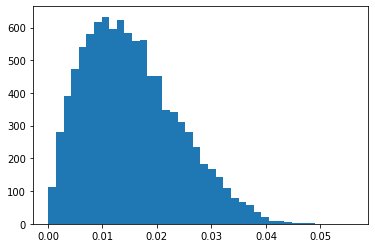

In [61]:
fig, ax = plt.subplots()
ax.hist(dfT15['e2'], weights=dfT15['T15stable'], bins=40)

(array([ 47., 134., 226., 323., 398., 438., 545., 615., 645., 691., 750.,
        795., 765., 740., 705., 682., 554., 461., 262.,  69.,  11.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.0001302 , 0.00209267, 0.00405513, 0.00601759, 0.00798005,
        0.00994251, 0.01190498, 0.01386744, 0.0158299 , 0.01779236,
        0.01975482, 0.02171728, 0.02367975, 0.02564221, 0.02760467,
        0.02956713, 0.03152959, 0.03349206, 0.03545452, 0.03741698,
        0.03937944, 0.0413419 , 0.04330437, 0.04526683, 0.04722929,
        0.04919175, 0.05115421, 0.05311667, 0.05507914, 0.0570416 ,
        0.05900406, 0.06096652, 0.06292898, 0.06489145, 0.06685391,
        0.06881637, 0.07077883, 0.07274129, 0.07470375, 0.07666622,
        0.07862868]),
 <a list of 40 Patch objects>)

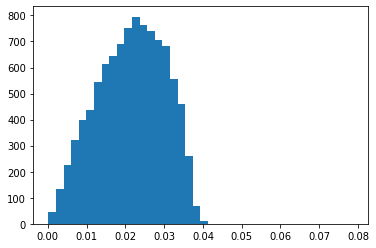

In [59]:
fig, ax = plt.subplots()
ax.hist(dfT15['Z12'], weights=dfT15['T15stable'], bins=40)

(array([ 59., 126., 227., 299., 418., 485., 574., 635., 733., 703., 699.,
        739., 790., 751., 709., 662., 606., 416., 196.,  29.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([8.97067613e-05, 2.05564797e-03, 4.02158918e-03, 5.98753039e-03,
        7.95347160e-03, 9.91941282e-03, 1.18853540e-02, 1.38512952e-02,
        1.58172364e-02, 1.77831777e-02, 1.97491189e-02, 2.17150601e-02,
        2.36810013e-02, 2.56469425e-02, 2.76128837e-02, 2.95788249e-02,
        3.15447661e-02, 3.35107073e-02, 3.54766486e-02, 3.74425898e-02,
        3.94085310e-02, 4.13744722e-02, 4.33404134e-02, 4.53063546e-02,
        4.72722958e-02, 4.92382370e-02, 5.12041782e-02, 5.31701195e-02,
        5.51360607e-02, 5.71020019e-02, 5.90679431e-02, 6.10338843e-02,
        6.29998255e-02, 6.49657667e-02, 6.69317079e-02, 6.88976491e-02,
        7.08635903e-02, 7.28295316e-02, 7.47954728e-02, 7.67614140e-02,
      

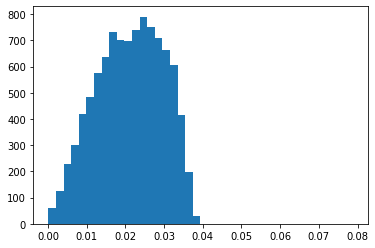

In [60]:
fig, ax = plt.subplots()
ax.hist(dfT15['Z23'], weights=dfT15['T15stable'], bins=40)

(array([[  9.37508166,  45.12454754,  83.6708566 ,  94.09124792,
         109.73468953, 113.14492176, 126.21075068,  93.08887883,
          73.4651714 ,  57.45872471],
        [ 36.51560342, 128.19674224, 207.28022164, 269.19489646,
         335.81934699, 332.16552502, 378.43935533, 301.48000371,
         242.32160794, 195.81939751],
        [ 71.13477057, 172.79482412, 325.03896827, 435.30318376,
         534.59884496, 547.69406343, 555.81929758, 487.2668075 ,
         394.95505922, 304.29507916],
        [ 78.83744782, 240.59802294, 417.13697645, 569.98422834,
         660.2393136 , 692.25863598, 668.91364224, 620.21715469,
         489.56713783, 432.23821688],
        [103.51729594, 279.7299522 , 468.16006918, 631.76332441,
         764.8350206 , 803.75973231, 756.85441864, 707.03559236,
         582.18761155, 491.68296339],
        [108.86255369, 304.67706844, 553.86709154, 716.96246332,
         825.44509461, 888.21093994, 826.71254376, 682.40272724,
         600.41929448, 482.142

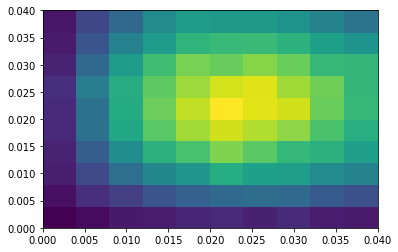

In [63]:
fig, ax = plt.subplots()
ax.hist2d(dfT15['Z12'], dfT15['Z23'], weights=dfT15['SPOCKstable'], range=([0,0.04], [0,0.04]))

In [67]:
1.5*3600/36

150.0

In [69]:
%%time
emax=max(emax1,emax2)
params = [(i,m0,m,a,3*emax) for i in range(150000)]
res = pool.map(runT15, params)

CPU times: user 7.71 s, sys: 5.16 s, total: 12.9 s
Wall time: 1h 24min 31s


In [68]:
emax

0.055916544863602466

In [70]:
df015 = pd.DataFrame(res, columns=['e1', 'e2', 'e3', 'Z12', 'Z23', 'ecom', 'T15stable', 'SPOCKstable'])

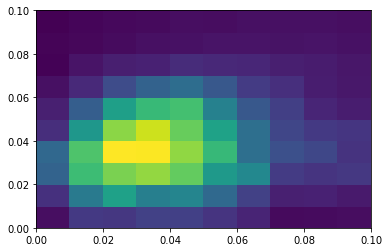

In [73]:
fig, ax = plt.subplots()
_ = ax.hist2d(df015['Z12'], df015['Z23'], weights=df015['SPOCKstable'], range=([0,0.1], [0,0.1]))

(array([5., 2., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.00037314, 0.02399926, 0.04762537, 0.07125148, 0.0948776 ,
        0.11850371, 0.14212982, 0.16575593, 0.18938205, 0.21300816,
        0.23663427]),
 <a list of 10 Patch objects>)

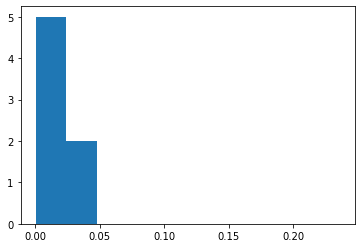

In [75]:
fig, ax = plt.subplots()
ax.hist(df015['Z12'], weights=df015['T15stable'])

In [ ]:
# deprecated...tau only applies for when you marginalize over a's, not for fixed a's. Efficientsample doesn't work, need uniform in all 3

In [ ]:
def calc_tau(sim, Deltacrit=9):
    m0, abar, m, a, ecross, ehill = calcarrays(sim)
    Delta_a = (a[-1]-a[0])
    F = abar*Deltacrit/Delta_a*ehill.sum()
    return Delta_a*(1-F)/6/(sim.N-1)/abar
    
def efficientsamplesim(m0, abar, m, a, ecross, ehill, Deltacrit=9):
    e = np.zeros(len(a))
    
    sim = rebound.Simulation()
    sim.add(m=m0)
    
    for i in range(len(a)):
        if i==0:
            emax1 = 1
        else:
            emax1 = ecross[i-1]-Deltacrit*ehill[i-1]-e[i-1]
        if i==len(a)-1:
            emax2 = 1
        else:
            emax2 = ecross[i]-Deltacrit*ehill[i]
        
        emax = min(emax1,emax2)
        if emax < 0:
            raise AttributeError('emax for planet{0} < 0'.format(i))
        e[i] = np.sqrt(random()*emax**2)
        sim.add(m=m[i], a=a[i], e=e[i], pomega=random()*2*np.pi, M=random()*2*np.pi)

    sim.move_to_com()
    
    return sim

In [285]:
def sample():
    e1 = random()
    e2 = random()*(1-e1)
    return e1, e2

In [290]:
emax=1
es = [np.sqrt(random()*emax**2) for i in range(10000)]

(array([ 116.,  302.,  518.,  666.,  923., 1129., 1269., 1473., 1745.,
        1859.]),
 array([0.00526289, 0.10473287, 0.20420285, 0.30367283, 0.40314281,
        0.50261279, 0.60208277, 0.70155275, 0.80102273, 0.90049271,
        0.99996269]),
 <a list of 10 Patch objects>)

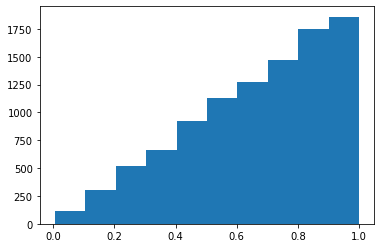

In [291]:
fig, ax = plt.subplots()
ax.hist(es)